In [ ]:

 
import os
import sys
import random
import argparse
import numpy as np
from PIL import Image, ImageFile

__version__ = '0.3.0'


IMAGE_DIR = os.path.join(os.path.dirname(os.path.abspath(__file__)), 'images')
DEFAULT_IMAGE_PATH = os.path.join(IMAGE_DIR, 'default-mask.png')
BLACK_IMAGE_PATH = os.path.join(IMAGE_DIR, 'black-mask.png')
BLUE_IMAGE_PATH = os.path.join(IMAGE_DIR, 'blue-mask.png')
RED_IMAGE_PATH = os.path.join(IMAGE_DIR, 'red-mask.png')


def cli():
    parser = argparse.ArgumentParser(description='Wear a face mask in the given picture.')
    parser.add_argument('pic_path', help='Picture path.')
    parser.add_argument('--show', action='store_true', help='Whether show picture with mask or not.')
    parser.add_argument('--model', default='hog', choices=['hog', 'cnn'], help='Which face detection model to use.')
    group = parser.add_mutually_exclusive_group()
    group.add_argument('--black', action='store_true', help='Wear black mask')
    group.add_argument('--blue', action='store_true', help='Wear blue mask')
    group.add_argument('--red', action='store_true', help='Wear red mask')
    args = parser.parse_args()

    pic_path = args.pic_path
    if not os.path.exists(args.pic_path):
        print(f'Picture {pic_path} not exists.')
        sys.exit(1)

    if args.black:
        mask_path = BLACK_IMAGE_PATH
    elif args.blue:
        mask_path = BLUE_IMAGE_PATH
    elif args.red:
        mask_path = RED_IMAGE_PATH
    else:
        mask_path = DEFAULT_IMAGE_PATH

    FaceMasker(pic_path, mask_path, args.show, args.model).mask()


def create_mask(image_path):
    pic_path = image_path
    mask_path = "/media/preeth/Data/prajna_files/mask_creator/face_mask/images/blue-mask.png"
    show = False
    model = "hog"
    FaceMasker(pic_path, mask_path, show, model).mask()



class FaceMasker:
    KEY_FACIAL_FEATURES = ('nose_bridge', 'chin')

    def __init__(self, face_path, mask_path, show=False, model='hog'):
        self.face_path = face_path
        self.mask_path = mask_path
        self.show = show
        self.model = model
        self._face_img: ImageFile = None
        self._mask_img: ImageFile = None

    def mask(self):
        import face_recognition

        face_image_np = face_recognition.load_image_file(self.face_path)
        face_locations = face_recognition.face_locations(face_image_np, model=self.model)
        face_landmarks = face_recognition.face_landmarks(face_image_np, face_locations)
        self._face_img = Image.fromarray(face_image_np)
        self._mask_img = Image.open(self.mask_path)

        found_face = False
        for face_landmark in face_landmarks:
            # check whether facial features meet requirement
            skip = False
            for facial_feature in self.KEY_FACIAL_FEATURES:
                if facial_feature not in face_landmark:
                    skip = True
                    break
            if skip:
                continue

            # mask face
            found_face = True
            self._mask_face(face_landmark)

        if found_face:
            if self.show:
                self._face_img.show()

            # save
            self._save()
        else:
            print('Found no face.')

    def _mask_face(self, face_landmark: dict):
        nose_bridge = face_landmark['nose_bridge']
        nose_point = nose_bridge[len(nose_bridge) * 1 // 4]
        nose_v = np.array(nose_point)

        chin = face_landmark['chin']
        chin_len = len(chin)
        chin_bottom_point = chin[chin_len // 2]
        chin_bottom_v = np.array(chin_bottom_point)
        chin_left_point = chin[chin_len // 8]
        chin_right_point = chin[chin_len * 7 // 8]

        # split mask and resize
        width = self._mask_img.width
        height = self._mask_img.height
        width_ratio = 1.2
        new_height = int(np.linalg.norm(nose_v - chin_bottom_v))

        # left
        mask_left_img = self._mask_img.crop((0, 0, width // 2, height))
        mask_left_width = self.get_distance_from_point_to_line(chin_left_point, nose_point, chin_bottom_point)
        mask_left_width = int(mask_left_width * width_ratio)
        mask_left_img = mask_left_img.resize((mask_left_width, new_height))

        # right
        mask_right_img = self._mask_img.crop((width // 2, 0, width, height))
        mask_right_width = self.get_distance_from_point_to_line(chin_right_point, nose_point, chin_bottom_point)
        mask_right_width = int(mask_right_width * width_ratio)
        mask_right_img = mask_right_img.resize((mask_right_width, new_height))

        # merge mask
        size = (mask_left_img.width + mask_right_img.width, new_height)
        mask_img = Image.new('RGBA', size)
        mask_img.paste(mask_left_img, (0, 0), mask_left_img)
        mask_img.paste(mask_right_img, (mask_left_img.width, 0), mask_right_img)

        # rotate mask
        angle = np.arctan2(chin_bottom_point[1] - nose_point[1], chin_bottom_point[0] - nose_point[0])
        rotated_mask_img = mask_img.rotate(angle, expand=True)

        # calculate mask location
        center_x = (nose_point[0] + chin_bottom_point[0]) // 2
        center_y = (nose_point[1] + chin_bottom_point[1]) // 2

        offset = mask_img.width // 2 - mask_left_img.width
        radian = angle * np.pi / 180
        box_x = center_x + int(offset * np.cos(radian)) - rotated_mask_img.width // 2
        box_y = center_y + int(offset * np.sin(radian)) - rotated_mask_img.height // 2

        # add mask
        self._face_img.paste(mask_img, (box_x, box_y), mask_img)

    def _save(self):
        path_splits = os.path.splitext(self.face_path)
        new_face_path = path_splits[0] + '-with-mask' + path_splits[1]
        self._face_img.save(new_face_path)
        print(f'Save to {new_face_path}')

    @staticmethod
    def get_distance_from_point_to_line(point, line_point1, line_point2):
        distance = np.abs((line_point2[1] - line_point1[1]) * point[0] +
                          (line_point1[0] - line_point2[0]) * point[1] +
                          (line_point2[0] - line_point1[0]) * line_point1[1] +
                          (line_point1[1] - line_point2[1]) * line_point1[0]) / \
                   np.sqrt((line_point2[1] - line_point1[1]) * (line_point2[1] - line_point1[1]) +
                           (line_point1[0] - line_point2[0]) * (line_point1[0] - line_point2[0]))
        return int(distance)


if __name__ == '__main__':
    #cli()
    create_mask(image_path)

In [ ]:
import cv2
import os
from mask import create_mask


folder_path = "/home/preeth/Downloads"
#dist_path = "/home/preeth/Downloads"

#c = 0
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
for i in range(len(images)):
    print("the path of the image is", images[i])
    #image = cv2.imread(images[i])
    #c = c + 1
    create_mask(images[i])



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import transform as tf
from sklearn import cluster

In [5]:
#% load the dataset
face_images_db = np.load('./input/face_images.npz')['face_images']
facial_keypoints_df = pd.read_csv('./input/facial_keypoints.csv')


In [7]:
#numMissingKeypoints = facial_keypoints_df.isnull().sum(axis=1)
#allKeypointsPresentInds = np.nonzero(numMissingKeypoints == 0)[0]

#faceImagesDB = face_images_db[:,:,allKeypointsPresentInds]
#facialKeypointsDF = facial_keypoints_df.iloc[allKeypointsPresentInds,:].reset_index(drop=True)

(imHeight, imWidth, numImages) = face_images_db.shape
numKeypoints = facial_keypoints_df.shape[1] / 2

print('number of remaining images = %d' %(numImages))
print('image dimentions = (%d,%d)' %(imHeight,imWidth))
print('number of facial keypoints = %d' %(numKeypoints))

number of remaining images = 7049
image dimentions = (96,96)
number of facial keypoints = 15


In [11]:
facial_keypoints_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,67.402546,31.842551,29.746749,38.632942,NaN,NaN,NaN,NaN,NaN,NaN,...,48.265961,67.029093,NaN,NaN,NaN,NaN,NaN,NaN,50.426637,79.683921
7045,66.134400,38.365501,30.478626,39.950198,NaN,NaN,NaN,NaN,NaN,NaN,...,47.910346,66.626011,NaN,NaN,NaN,NaN,NaN,NaN,50.287397,77.983023
7046,66.690732,36.845221,31.666420,39.685042,NaN,NaN,NaN,NaN,NaN,NaN,...,49.462572,67.515161,NaN,NaN,NaN,NaN,NaN,NaN,49.462572,78.117120
7047,70.965082,39.853666,30.543285,40.772339,NaN,NaN,NaN,NaN,NaN,NaN,...,50.754202,66.724988,NaN,NaN,NaN,NaN,NaN,NaN,50.065186,79.586447


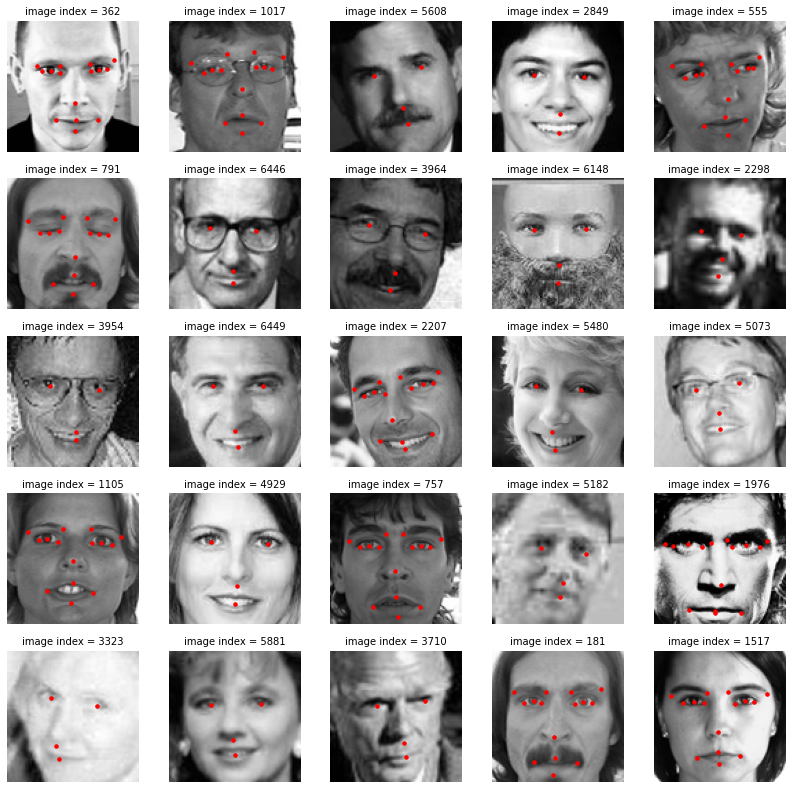

In [9]:
# show a random subset of images from the dataset
num_fig_rows = 5
num_fig_cols = 5

num_plots = num_fig_rows * num_fig_cols

rand_inds_vec = np.random.choice(face_images_db.shape[2],num_plots,replace=False)
rand_inds_mat = rand_inds_vec.reshape((num_fig_rows,num_fig_cols))

plt.close('all')
fig, ax = plt.subplots(nrows=num_fig_rows,ncols=num_fig_cols,figsize=(14,14))

for i in range(num_fig_rows):
    for j in range(num_fig_cols):
        curr_ind = rand_inds_mat[i][j]
        curr_image = face_images_db[:,:,curr_ind]
    
        x_feature_coords = np.array(facial_keypoints_df.iloc[curr_ind,0:30:2].tolist())
        y_feature_coords = np.array(facial_keypoints_df.iloc[curr_ind,1:30:2].tolist())
    
        ax[i][j].imshow(curr_image, cmap='gray');
        ax[i][j].scatter(x_feature_coords,y_feature_coords,c='r',s=12)
        ax[i][j].set_axis_off()
        ax[i][j].set_title('image index = %d' %(curr_ind),fontsize=10)